# Análise de Imagem de Túnel por Setores

Este notebook realiza a análise setorial de uma imagem de túnel, classificando cada setor em proporções de:


🌌 Céu

🛣️ Pavimento

🪨 Rochas

🏢 Edifícios

🌿 Matas

🚇 Túnel

Os resultados são exportados para um CSV.

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ipympl


Note: you may need to restart the kernel to use updated packages.


In [5]:
%matplotlib widget


## Depois de confirmar que tudo esteja instalado, comece o programa daqui

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Dropdown, VBox, FileUpload
from io import BytesIO



In [2]:
# Widget de upload
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description="Upload Imagem"
)

uploader

FileUpload(value=(), accept='image/*', description='Upload Imagem')

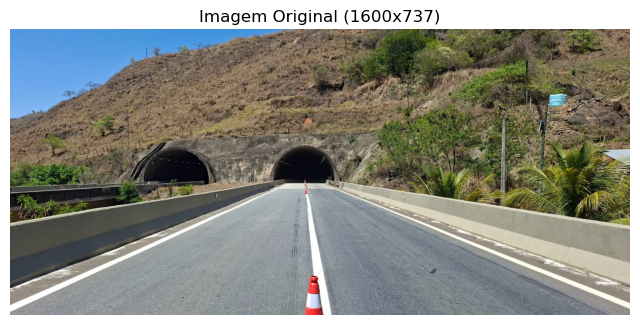

In [4]:
# Pegar o arquivo enviado (compatível com tuple ou dict)
if uploader.value:
    if isinstance(uploader.value, dict):
        # Versão antiga
        nome, arquivo = list(uploader.value.items())[0]
        conteudo = arquivo['content']
    else:
        # Versão nova (tuple/list)
        arquivo = uploader.value[0]
        nome = arquivo['name']
        conteudo = arquivo['content']

    # Converter bytes → numpy array → imagem OpenCV
    bytes_imagem = np.frombuffer(conteudo, np.uint8)
    img = cv2.imdecode(bytes_imagem, cv2.IMREAD_COLOR)  # BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)          # RGB

    h, w, _ = img.shape

    # Mostrar imagem
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.title(f"Imagem Original ({w}x{h})")
    plt.axis("off")
    plt.show()
else:
    print("⚠️ Nenhuma imagem foi enviada ainda.")


# Tratamento de Imagem

HSV é a abreviatura para o sistema de cores formadas pelas componentes hue (matiz), saturation (saturação) e value (valor). O HSV também é conhecido como HSB (hue, saturation e brightness — matiz, saturação e brilho, respectivamente). Esse sistema de cores define o espaço de cor conforme descrito abaixo, utilizando seus três parâmetros:

Matiz (tonalidade): Verifica o tipo de cor, abrangendo todas as cores do espectro, desde o vermelho até o violeta, mais o magenta. Atinge valores de 0 a 360, mas para algumas aplicações, esse valor é normalizado de 0 a 100%.
Saturação: Também chamado de "pureza". Quanto menor esse valor, mais com tom de cinza aparecerá a imagem. Quanto maior o valor, mais "pura" é a imagem. Atinge valores de 0 a 100%.
Valor (brilho): Define o brilho da cor. Atinge valores de 0 a 100%.

True

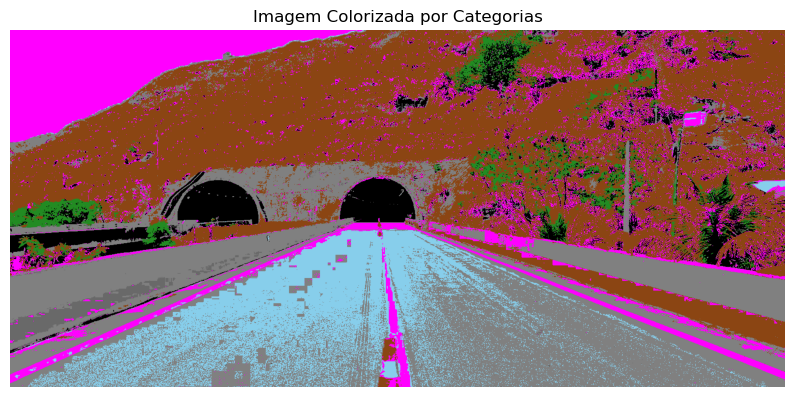

In [5]:
# Dicionário com cores RGB para cada categoria
cores = {
    "ceu": (135, 206, 235),         # azul claro
    "pavimento": (128, 128, 128),   # cinza
    "rochas": (139, 69, 19),        # marrom
    "edificios": (105, 105, 105),   # cinza escuro
    "matas": (34, 139, 34),         # verde
    "tunnel": (0, 0, 0),            # preto
    "desconhecido": (255, 0, 255)   # magenta
}

def classificar_pixel(h, s, v):
    # Céu: tons claros e pouco saturados (azul claro, céu diurno)
    if (h >= 90 and h <= 130) and v > 150 and s < 80:
        return "ceu"
    
    # Pavimento: tons claros de cinza, baixa saturação
    elif 60 <= v < 180 and s < 50:  # ajustado para pegar tons mais claros
        return "pavimento"
    
    # Rochas: tons acastanhados, cinza ou bege
    elif (0 <= h <= 40 or 20 <= h <= 30) and s > 30 and v > 80:
        return "rochas"
    
    # Edifícios: geralmente cinza/escuro, saturação média
    elif s < 60 and 50 < v < 180:
        return "edificios"
    
    # Vegetação/matas: tons de verde
    elif 35 <= h <= 85 and s > 40 and v > 50:
        return "matas"
    
    # Túnel: muito escuro, pouco saturado
    elif v < 50:
        return "tunnel"
    
    else:
        return "desconhecido"

# --- Pipeline de segmentação ---


# Converter para HSV
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Achatar HSV para iterar pixel a pixel
pixels_hsv = hsv_img.reshape(-1, 3)

# Classificar pixels
classes = [classificar_pixel(h, s, v) for h, s, v in pixels_hsv]

# Criar imagem segmentada com as cores
img_colorizada = np.array([cores.get(cls, (255, 0, 255)) for cls in classes], dtype=np.uint8)

# Reshape para tamanho original
img_colorizada = img_colorizada.reshape(img.shape)

# Mostrar resultado e salvar imagem
plt.figure(figsize=(10,10))
plt.imshow(img_colorizada)
plt.title("Imagem Colorizada por Categorias")
plt.axis("off")

# Salvar a figura
cv2.imwrite("imagem_colorizada.png", cv2.cvtColor(img_colorizada, cv2.COLOR_RGB2BGR))


## Após a edição da imagem_colorizada no paint, reinsira o arquivo para gerar os dados tabelados

In [6]:
import ipywidgets as widgets
from IPython.display import display

# Widget de upload
uploader_colorizada = widgets.FileUpload(
    accept='image/*',  # aceitar imagens
    multiple=False,
    description="📂 Upload Imagem Colorizada"
)

# Output para mostrar a imagem
output_colorizada = widgets.Output()

def carregar_colorizada(change):
    output_colorizada.clear_output()
    
    if uploader_colorizada.value:
        # Compatível com tuple/list
        arquivo = uploader_colorizada.value[0]
        nome = arquivo['name']
        conteudo = arquivo['content']
        
        # Mostrar a imagem diretamente como widget.Image
        img_widget = widgets.Image(
            value=conteudo,
            format=nome.split('.')[-1],
            width=400,
            height=400
        )
        
        with output_colorizada:
            display(img_widget)
            
        # Guardar a imagem em memória para processamento futuro
        global img_colorizada_bytes
        img_colorizada_bytes = conteudo

# Conectar evento
uploader_colorizada.observe(carregar_colorizada, names='value')

# Exibir interface
widgets.VBox([uploader_colorizada, output_colorizada])


#  Variaveis para Setorização

### Cálculo de Setores Concêntricos

Para definir setores concêntricos em uma imagem ou planta de túnel, seguimos os seguintes passos:

1. **Escolha dos ângulos**  
   Definimos uma sequência de ângulos em graus que representam a abertura de cada coroa concêntrica a partir do ponto central. Cada ângulo indica a inclinação radial correspondente à distância do túnel.

2. **Conversão para radianos**  
   Como funções trigonométricas (como a tangente) trabalham com radianos, convertemos cada ângulo $\theta$ de graus para radianos:

   $$
   \theta_{\text{rad}} = \theta_{\text{graus}} \cdot \frac{\pi}{180}
   $$

3. **Cálculo dos raios**  
   Para cada ângulo em radianos, calculamos o raio da coroa usando a tangente:

   $$
   r = d \cdot \tan(\theta_{\text{rad}})
   $$

   Onde:  
   - $r$ é o raio da coroa concêntrica na imagem,  
   - $d$ é a distância do ponto central até o túnel,  
   - $\theta_{\text{rad}}$ é o ângulo em radianos.

4. **Formação das coroas concêntricas**  
   Cada valor de raio define a posição de um círculo concêntrico. Entre dois raios consecutivos, forma-se uma “coroa” que pode ser dividida em setores angulares. Cada setor cobre um intervalo de ângulos:

   $$
   \text{Setor } j: \quad \theta_{\text{in}} = \frac{2 \pi j}{N}, \quad 
   \theta_{\text{out}} = \frac{2 \pi (j+1)}{N}
   $$

   Onde $N$ é o número de setores angulares por coroa.

Dessa forma, combinando **raios concêntricos** e **divisões angulares**, obtemos uma malha de setores que cobre toda a área de interesse, útil para segmentação de imagens, análise de iluminação ou estudo de visibil


In [33]:
# --- Converter imagem do uploader para numpy ---
img_colorizada = bytes_para_cv2(img_colorizada_bytes)

# --- Parâmetros da imagem ---
h, w, _ = img_colorizada.shape
h_camera = 2.5
altura_visivel = 5.0

# --- Parâmetros dos setores ---
num_setores  = 12
distancia_tunel = 150
angulos_graus = [2.0, 3.0, 4.0, 5.8, 8.0, 11.6, 16.6, 24.0, 36.0, 56.8]
lista_angulos = np.radians(angulos_graus)
lista_raios = [distancia_tunel * np.tan(theta) for theta in lista_angulos]

# --- Centro inicial calculado pela altura da câmera ---
x_center_inicial = w // 2
y_center_inicial = int(h - (h_camera / altura_visivel) * h)

# --- Sliders interativos ---
interact(
    atualizar_setores,
    x_center=IntSlider(min=0, max=w, step=1, value=x_center_inicial, description='X Center'),
    y_center=IntSlider(min=0, max=h, step=1, value=y_center_inicial, description='Y Center')
)


interactive(children=(IntSlider(value=800, description='X Center', max=1600), IntSlider(value=368, description…

<function __main__.atualizar_setores(x_center, y_center)>

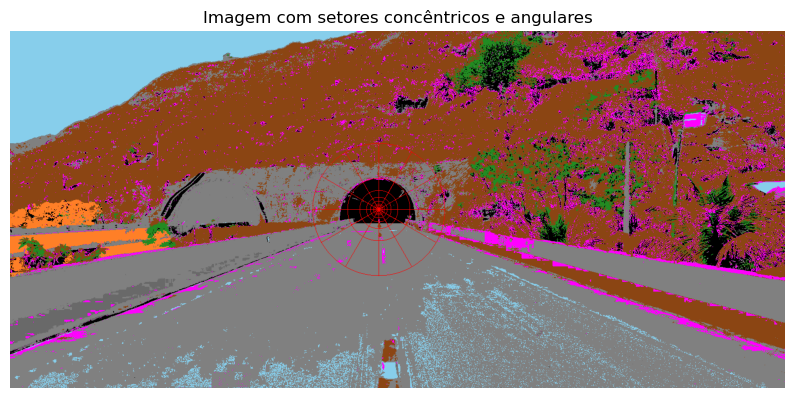

In [24]:
# --- Garantir que a imagem e o center estão definidos ---
# img_colorizada: imagem carregada do uploader (RGB)
# center: ponto central (x_center_inicial, y_center_inicial)

# --- Geração de setores concêntricos e angulares ---
def gerar_setores_conc_ang(h, w, center, lista_raios, num_setores):
    """
    Gera setores concêntricos e angulares a partir de um ponto central.

    h, w           -> dimensões da imagem
    center         -> ponto central (x, y)
    lista_raios    -> lista de raios [r1, r2, r3,...] para círculos/coroas
    num_setores    -> número de divisões angulares por coroa
    """
    setores = []
    Y, X = np.ogrid[:h, :w]
    dx, dy = X - center[0], Y - center[1]

    R = np.sqrt(dx**2 + dy**2)
    Theta = (np.arctan2(dy, dx) + 2*np.pi) % (2*np.pi)  # [0, 2pi)

    raio_in = 0
    for raio_out in lista_raios:
        for j in range(num_setores):
            ang_in = 2 * np.pi * j / num_setores
            ang_out = 2 * np.pi * (j + 1) / num_setores

            mask = (R > raio_in) & (R <= raio_out) & (Theta >= ang_in) & (Theta < ang_out)
            setores.append(mask.astype(np.uint8))

        raio_in = raio_out

    return setores

# --- Parâmetros ---
h, w, _ = img_colorizada.shape
num_setores = 12

# --- Gerar setores ---
setores = gerar_setores_conc_ang(h, w, center, lista_raios, num_setores)

# --- Visualizar setores sobre a imagem ---
img_setores = desenhar_setores(img_colorizada, center, lista_raios, num_setores, cor=(255,0,0), espessura=1)

plt.figure(figsize=(10,10))
plt.imshow(img_setores)  # já RGB
plt.title("Imagem com setores concêntricos e angulares")
plt.axis("off")
plt.show()


In [25]:
# --- Classificação de pixels usando RGB ---
def classificar_pixel_rgb(pixel):
    """
    pixel: array [R,G,B]
    retorna a categoria correspondente usando o dicionário 'cores'
    """
    for cat, cor in cores.items():
        if np.all(pixel == cor):
            return cat
    return "desconhecido"

# --- Pipeline de contagem por setores ---
resultados = []

# Gerar setores concêntricos e angulares
setores = gerar_setores_conc_ang(h, w, center, lista_raios, num_setores)
print(f"Total de setores: {len(setores)}")  # Ex.: 10 raios * 12 setores = 120 setores

for idx, mask in enumerate(setores):
    # Pegar pixels da imagem colorizada diretamente
    pixels = img_colorizada[mask == 1]
    if len(pixels) == 0:
        continue
    
    # Classificar todos os pixels do setor pelo RGB
    classes = [classificar_pixel_rgb(p) for p in pixels]
    total = len(classes)

    # Contagem relativa por categoria (%)
    contagens = {"setor": idx}
    for cat in set(classes):
        contagens[cat] = classes.count(cat) / total * 100

    # Determina anel (de dentro para fora) e segmento (sentido horário)
    contagens['anel'] = idx // num_setores
    contagens['segmento'] = (idx % num_setores) + 1

    resultados.append(contagens)

# Criar DataFrame e preencher NaNs com 0
df = pd.DataFrame(resultados).fillna(0)

# Opcional: manter só a partir da linha 12
df = df.iloc[12:].reset_index(drop=True)

print(df.shape)  # Deve refletir o número total de setores (linhas) e categorias (colunas)
df.head()


Total de setores: 120
(108, 10)


,setor,tunnel,anel,segmento,edificios,desconhecido,pavimento,rochas,matas,ceu
0,12,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1,13,100.0,1,2,0.0,0.0,0.0,0.0,0.0,0.0
2,14,100.0,1,3,0.0,0.0,0.0,0.0,0.0,0.0
3,15,100.0,1,4,0.0,0.0,0.0,0.0,0.0,0.0
4,16,100.0,1,5,0.0,0.0,0.0,0.0,0.0,0.0


## classificação da imagem completa, dependendo do tamanho do arquivo, pode demorar

In [26]:
# Seleciona todos os pixels da imagem colorizada
pixels = img_colorizada.reshape(-1, 3)  # todos os pixels da imagem

# Classifica cada pixel usando RGB
classes = [classificar_pixel_rgb(p) for p in pixels]  # p é [R,G,B]
total = len(classes)

# Contagem relativa por categoria (%)
contagens = {}
for cat in set(classes):
    contagens[cat] = classes.count(cat) / total * 100  # % de pixels por categoria

# Cria DataFrame de uma linha
df_total = pd.DataFrame([contagens])
print(df_total)


   desconhecido  pavimento     rochas    tunnel     matas      ceu  edificios
0      7.600492  38.688094  36.425712  4.795115  2.394335  8.60558   1.490672


# Análise de Setores Por Cor

In [27]:
df = df.round(2)  # arredonda todas as colunas numéricas para 2 casas decimais
df.to_csv("resultado_setores.csv", index=False)

In [28]:
output_csv = "analise_tunel.csv"
df.to_csv(output_csv, index=False,float_format="%.2f")
print(f"CSV salvo em: {output_csv}")



CSV salvo em: analise_tunel.csv


In [29]:
df.head(24)

,setor,tunnel,anel,segmento,edificios,desconhecido,pavimento,rochas,matas,ceu
0,12,100.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1,13,100.0,1,2,0.0,0.0,0.0,0.0,0.0,0.0
2,14,100.0,1,3,0.0,0.0,0.0,0.0,0.0,0.0
3,15,100.0,1,4,0.0,0.0,0.0,0.0,0.0,0.0
4,16,100.0,1,5,0.0,0.0,0.0,0.0,0.0,0.0
5,17,100.0,1,6,0.0,0.0,0.0,0.0,0.0,0.0
6,18,100.0,1,7,0.0,0.0,0.0,0.0,0.0,0.0
7,19,100.0,1,8,0.0,0.0,0.0,0.0,0.0,0.0
8,20,100.0,1,9,0.0,0.0,0.0,0.0,0.0,0.0
9,21,100.0,1,10,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df.tail(24)

,setor,tunnel,anel,segmento,edificios,desconhecido,pavimento,rochas,matas,ceu
84,96,85.97,8,1,1.54,1.82,6.45,4.07,0.14,0.00
85,97,12.46,8,2,0.14,0.14,84.10,0.29,0.00,2.87
86,98,0.00,8,3,0.00,2.91,90.26,6.10,0.00,0.73
87,99,0.00,8,4,0.00,3.79,94.67,1.54,0.00,0.00
88,100,11.75,8,5,0.57,5.44,82.23,0.00,0.00,0.00
89,101,82.27,8,6,3.34,0.87,13.23,0.29,0.00,0.00
90,102,96.91,8,7,1.26,0.14,1.68,0.00,0.00,0.00
91,103,99.43,8,8,0.14,0.00,0.43,0.00,0.00,0.00
92,104,92.73,8,9,0.44,6.25,0.58,0.00,0.00,0.00
93,105,89.76,8,10,1.96,7.57,0.70,0.00,0.00,0.00


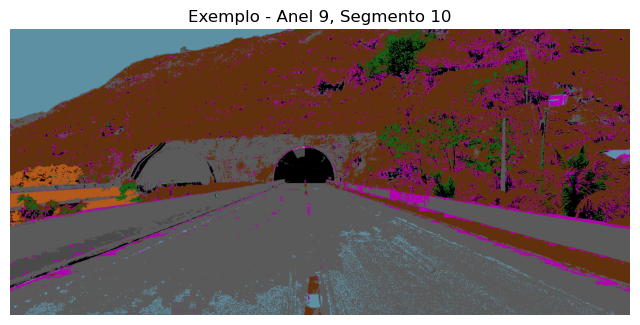

In [31]:
# Parâmetros do setor que você quer visualizar
anel_exemplo = 9        # anel de dentro para fora (0 = centro)
segmento_exemplo = 10
# segmento no sentido horário (1..num_setores)

# Calcular índice do setor
setor_exemplo = anel_exemplo * num_setores + (segmento_exemplo - 1)
setor_exemplo=104

# Criar máscara RGB e overlay
mask_rgb = np.dstack([setores[setor_exemplo]*255]*3)
overlay = cv2.addWeighted(img_colorizada, 0.7, mask_rgb, 0.3, 0)

# Visualizar
plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.title(f"Exemplo - Anel {anel_exemplo}, Segmento {segmento_exemplo}")
plt.axis("off")
plt.show()
